# Тестирование производительности
## Описание экспериментов
Данный блокнот сделан с целью тестирования производительности разных методов выбора длины шага в оптимизации динамической регрессии. Методы будут тестироваться следующие:
- Константный выбор $\alpha = 10^{-8}$
- Выбор по формуле $\alpha_k = \lambda \left( \frac{s_0}{s_0 + k} \right)^p$, где $\lambda = 2 * 10^{-8}$, $s_0 = 1$, $p=0.5$.
- Линейный поиск $\alpha$, удовлетворяющего условиям Армихо (стартовый $\alpha = 10^{-7}$)
- Линейный поиск $\alpha$, удовлетворяющего условиям Вульфа (стартовый $\alpha = 10^{-7}$)

Я возьму 15 рядов разной сезонности из датасета M4 и изображу графики зависимости функции потерь от итерации, функции потерь от времени и относительной точности ($\frac{\|x_k\|_2^2}{\|x_0\|_2^2}$) от времени для каждого ряда отдельно, для обычной динамической регрессии и для сезонной. Также затем построю графики зависимости времени и количества итераций от размера ряда и от его сезонности.

Параметры для динамических регрессий будут браться следующие:
- Для обычной --  `fh=[5]`, `sp=None`, `learning_steps='all'`, `ar_depth=5`, `seas_depth=2`, `fit_intercept=True`, `max_iter=100`, `tolerance=1e-5`.
- Для сезонной -- `fh=[5]`, `learning_steps='all'`, `ar_depth=5`, `seas_depth=2`, `fit_intercept=True`, `max_iter=100`, `tolerance=1e-5`, а параметр `sp` будет зависеть от сезонности ряда -- для часовых `sp=24`, для дневных `sp=30`, для недельных `sp=4`, для квартальных `sp=4`, для месячных `sp=12`, для годовых `sp=10`.

Будут тестироваться следующие гипотезы:
- Самый быстрый метод выбора длины шага -- (константный|по формуле|Армихо|Вульф), критерием для этого является более быстрая скорость сходимости по времени в 66% случаев.
- Самый надёжный метод выбора длины шага -- (константный|по формуле|Армихо|Вульф), критерием для этого является наименьшее число отсутствий сходимости суммарно по всем рядам.
- Самый быстрый метод совпадает с самым надёжным.
- Обычная динамическая регрессия оценивается быстрее, чем сезонная, критерием для этого является более быстрая скорость сходимости по времени в 66% случаев.
- Размер ряда обратно пропорционален скорости его сходимости, критерием для этого является нисходящий тренд скорости сходимости по времени от размера ряда для всех методов.
- Сезонность ряда (параметр `sp`) не влияет на скорость сходимости, критерием для этого является боковой тренд скорости сходимости по времени от сезонности ряда.
- Текущая реализация слишком медленная, критерием для этого является то, что лучший по скорости метод работает дольше 7 секунд в 66% случаев.
- Для оптимизации обычной динамической регрессии хватит max_iter=20. Критерием для этого будет сходимость всех рядов с помощью лучшего по скорости метода менее, чем за max_iter итераций.

## Эксперименты

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from dynamic_regression import DynamicRegression
from models import SktimeETS, SktimeARIMA, SktimeLinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set(style="darkgrid")

/usr/local/lib/python3.9/site-packages/sktime/utils/validation/series.py:22: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/usr/local/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:25: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.TimedeltaIndex)
/usr/local/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:26: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.PeriodIndex)
/usr/local/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed f

### Ряд 1. Часовой, размер = 700

<AxesSubplot:>

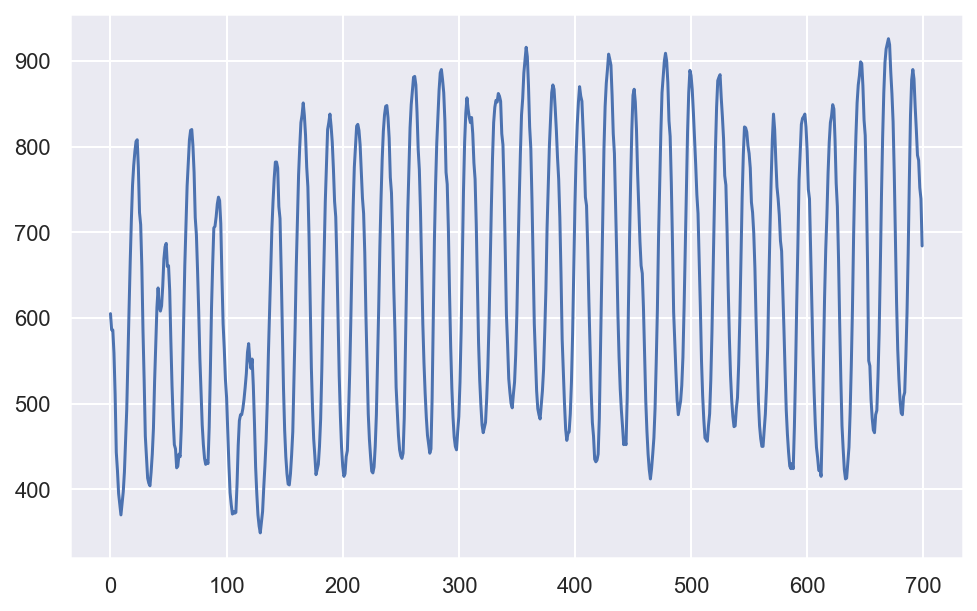

In [2]:
hourly_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Hourly-train.csv")
testing_series_1 = hourly_dataset[hourly_dataset["V1"] == "H1"].squeeze().dropna().drop(index='V1')
testing_series_1.index = range(len(testing_series_1))
testing_series_1 = testing_series_1.astype(np.float64)
len(testing_series_1)
testing_series_1.plot()

### Ряд 2. Часовой, размер = 960

960


<AxesSubplot:>

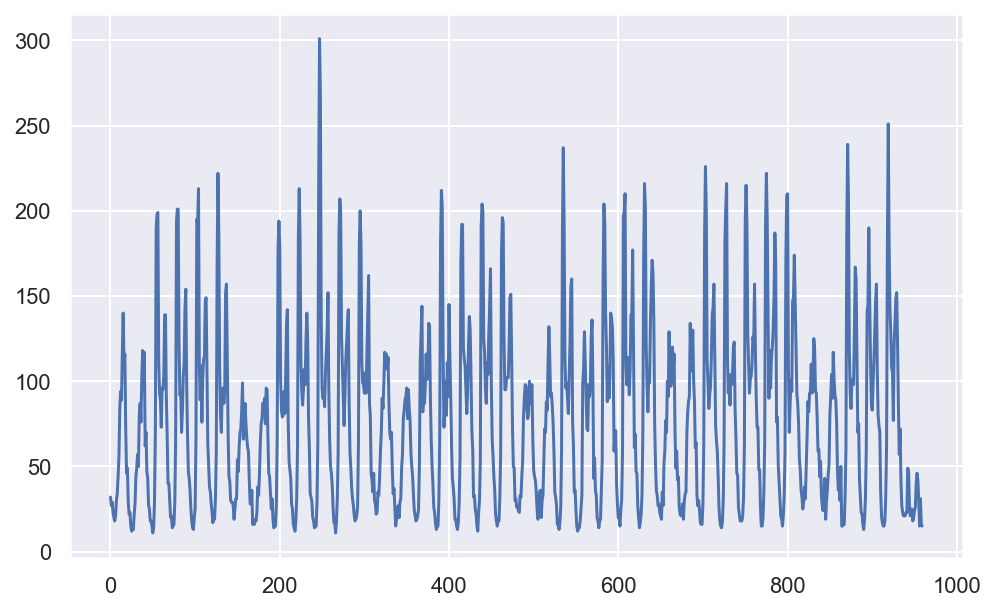

In [40]:
testing_series_2 = hourly_dataset[hourly_dataset["V1"] == "H400"].squeeze().dropna().drop(index='V1')
testing_series_2.index = range(len(testing_series_2))
testing_series_2 = testing_series_2.astype(np.float64)
print(len(testing_series_2))
testing_series_2.plot()

### Ряд 3. Дневной, размер = 1006

1006


<AxesSubplot:>

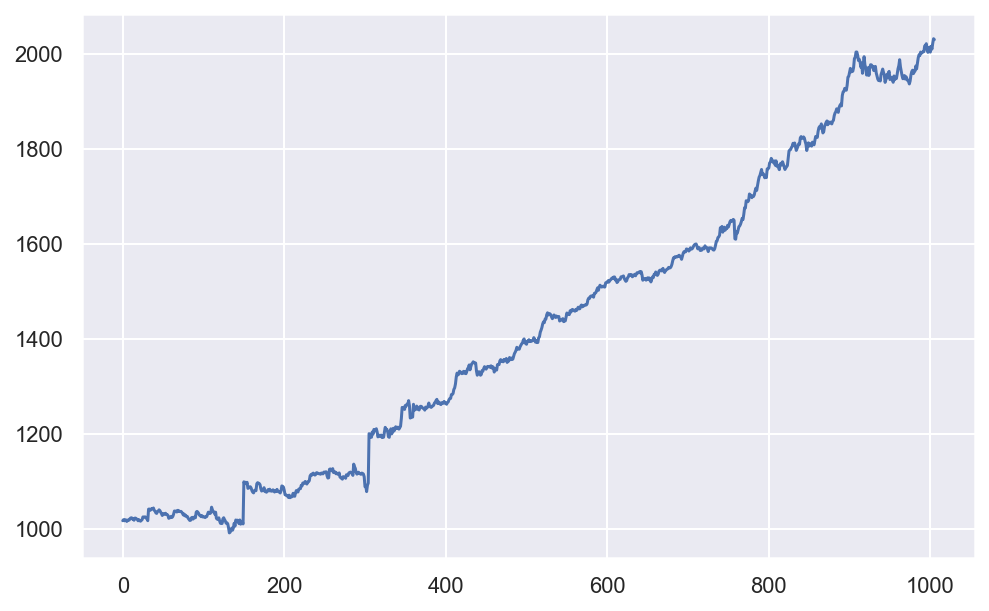

In [15]:
daily_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Daily-train.csv")
testing_series_3 = daily_dataset[daily_dataset["V1"] == "D1"].squeeze().dropna().drop(index='V1')
testing_series_3.index = range(len(testing_series_3))
testing_series_3 = testing_series_3.astype(np.float64)
print(len(testing_series_3))
testing_series_3.plot()

### Ряд 4. Дневной, размер = 130

130


<AxesSubplot:>

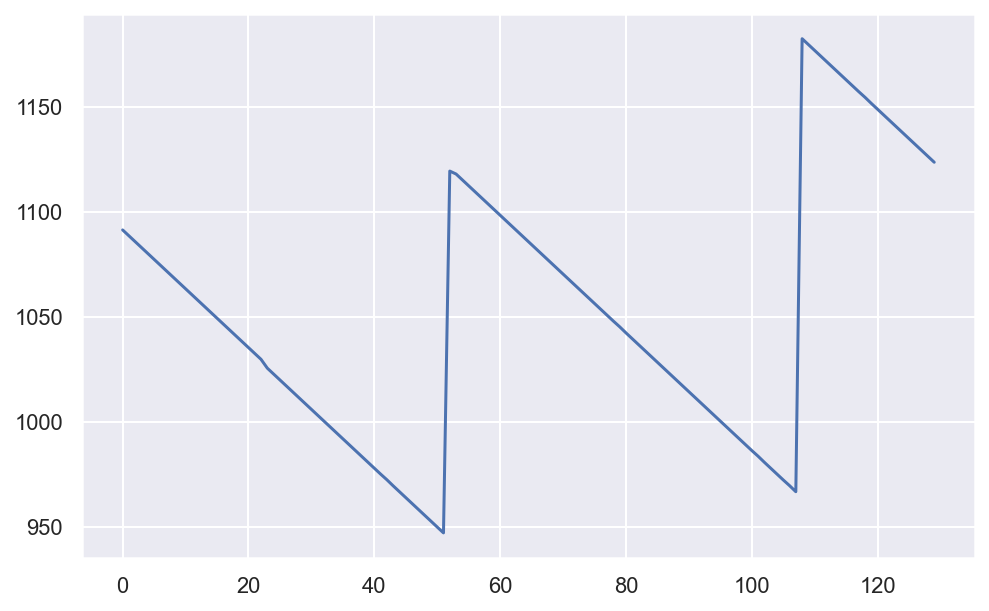

In [41]:
testing_series_4 = daily_dataset[daily_dataset["V1"] == "D3"].squeeze().dropna().drop(index='V1')
testing_series_4.index = range(len(testing_series_4))
testing_series_4 = testing_series_4.astype(np.float64)
print(len(testing_series_4))
testing_series_4.plot()

### Ряд 5. Недельный, размер = 2179

2179


<AxesSubplot:>

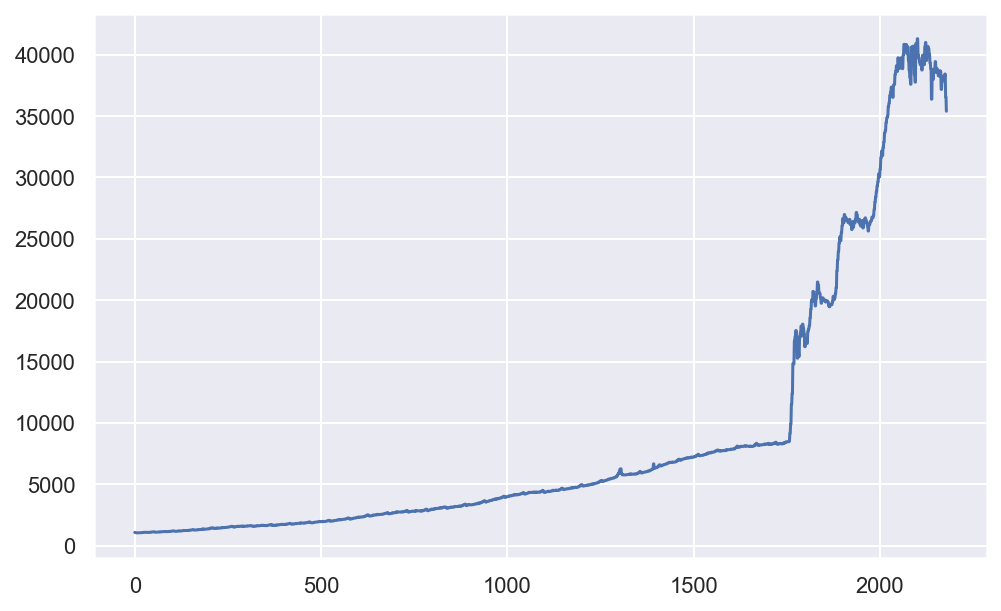

In [19]:
weekly_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Weekly-train.csv")
testing_series_5 = weekly_dataset[weekly_dataset["V1"] == "W1"].squeeze().dropna().drop(index='V1')
testing_series_5.index = range(len(testing_series_5))
testing_series_5 = testing_series_5.astype(np.float64)
print(len(testing_series_5))
testing_series_5.plot()

### Ряд 6. Недельный, размер = 1710

1710


<AxesSubplot:>

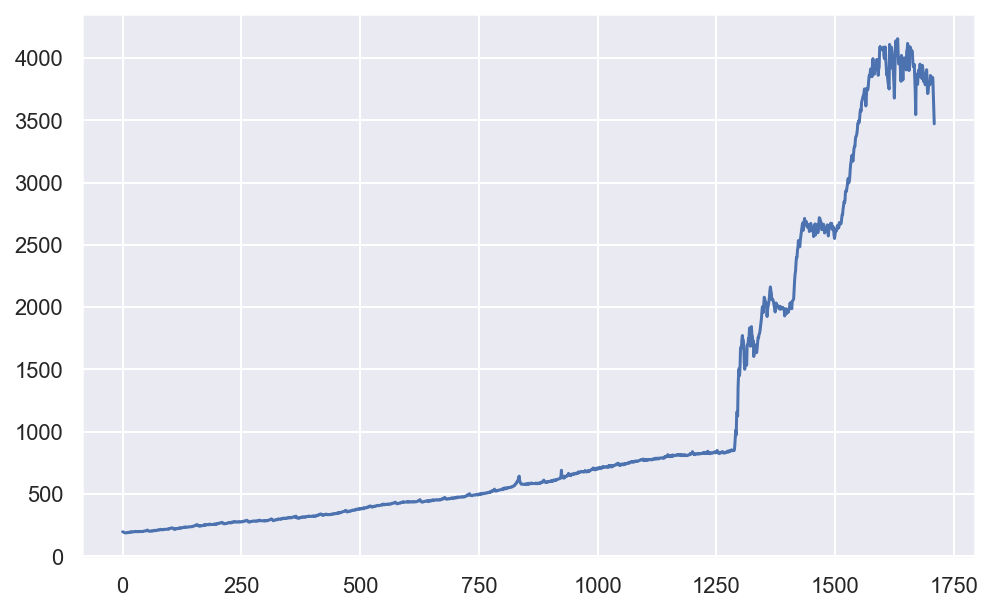

In [20]:
testing_series_6 = weekly_dataset[weekly_dataset["V1"] == "W2"].squeeze().dropna().drop(index='V1')
testing_series_6.index = range(len(testing_series_6))
testing_series_6 = testing_series_6.astype(np.float64)
print(len(testing_series_6))
testing_series_6.plot()

### Ряд 7. Месячный, размер = 469

469


<AxesSubplot:>

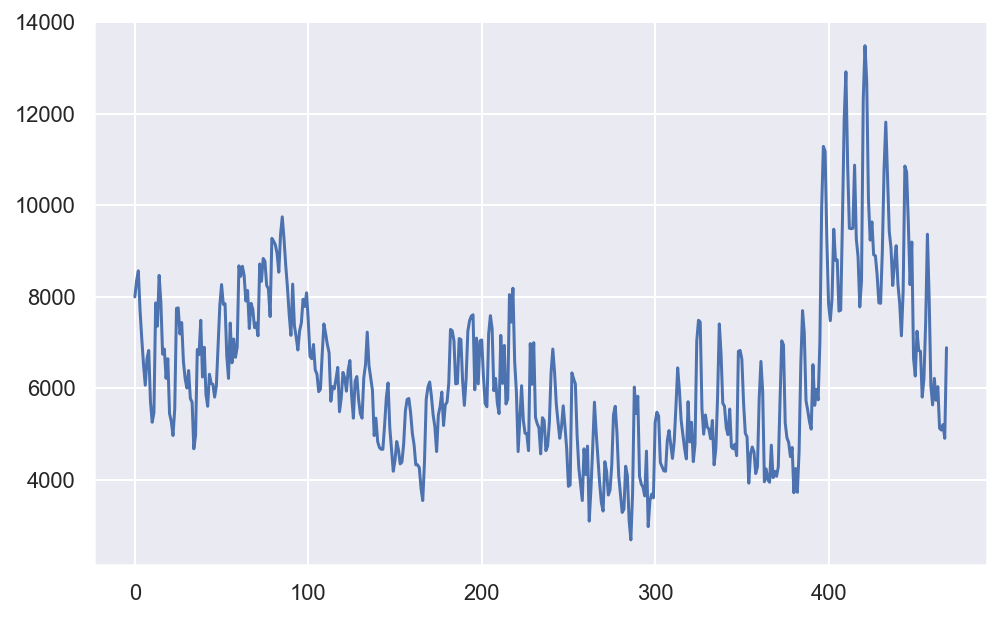

In [21]:
monthly_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Monthly-train.csv")
testing_series_7 = monthly_dataset[monthly_dataset["V1"] == "M1"].squeeze().dropna().drop(index='V1')
testing_series_7.index = range(len(testing_series_7))
testing_series_7 = testing_series_7.astype(np.float64)
print(len(testing_series_7))
testing_series_7.plot()

### Ряд 8. Месячный, размер = 366

366


<AxesSubplot:>

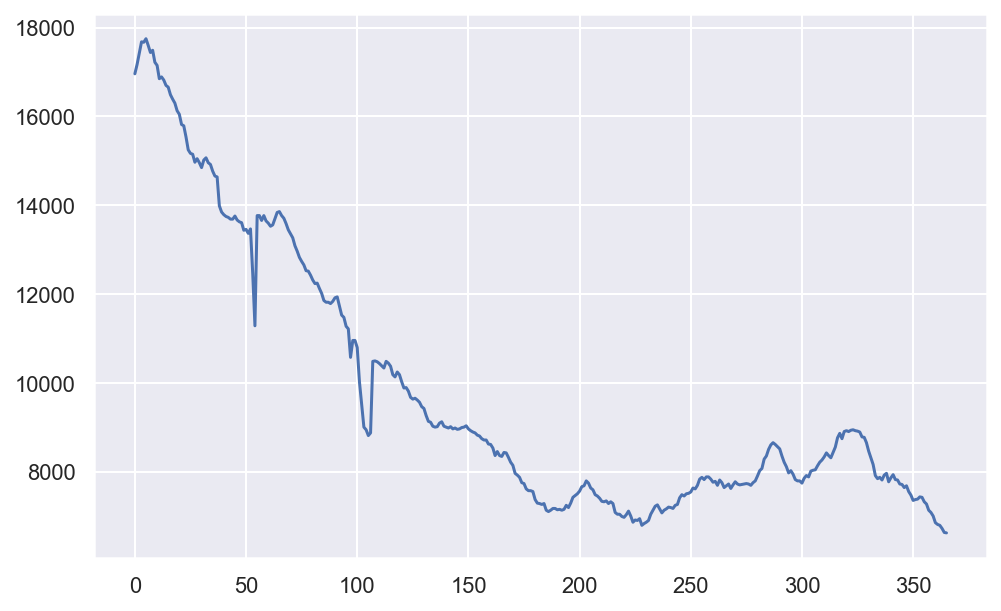

In [42]:
testing_series_8 = monthly_dataset[monthly_dataset["V1"] == "M10"].squeeze().dropna().drop(index='V1')
testing_series_8.index = range(len(testing_series_8))
testing_series_8 = testing_series_8.astype(np.float64)
print(len(testing_series_8))
testing_series_8.plot()

### Ряд 9. Месячный, размер = 292

292


<AxesSubplot:>

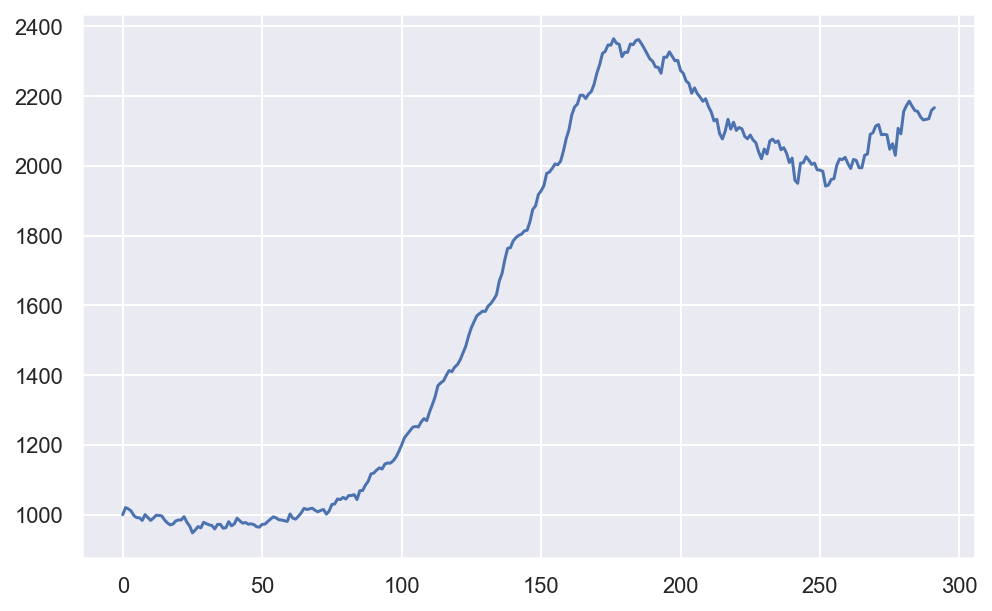

In [43]:
testing_series_9 = monthly_dataset[monthly_dataset["V1"] == "M100"].squeeze().dropna().drop(index='V1')
testing_series_9.index = range(len(testing_series_9))
testing_series_9 = testing_series_9.astype(np.float64)
print(len(testing_series_9))
testing_series_9.plot()

### Ряд 10. Квартальный, размер = 25

25


<AxesSubplot:>

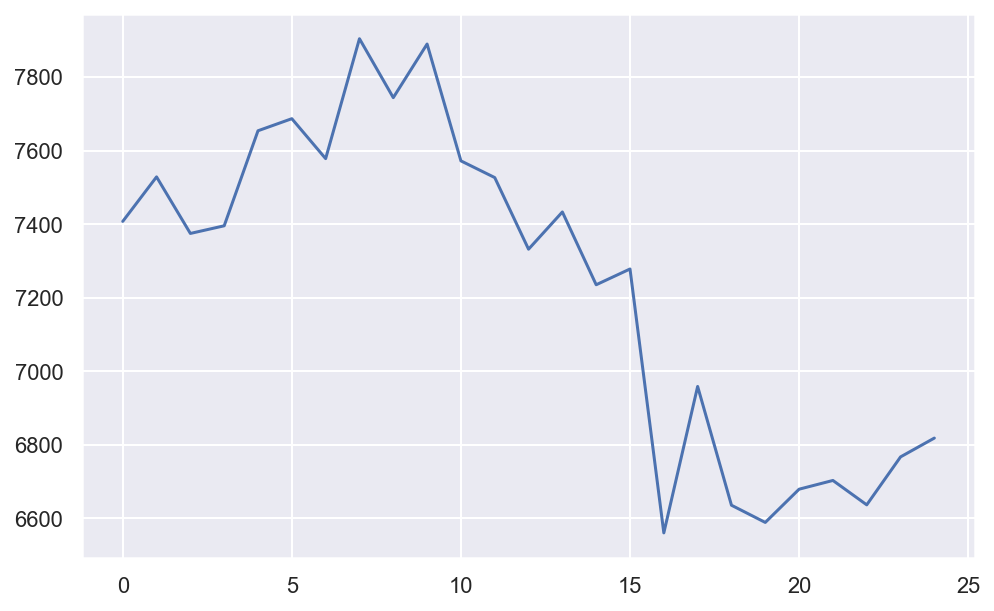

In [25]:
quarterly_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Quarterly-train.csv")
testing_series_10 = quarterly_dataset[quarterly_dataset["V1"] == "Q1"].squeeze().dropna().drop(index='V1')
testing_series_10.index = range(len(testing_series_10))
testing_series_10 = testing_series_10.astype(np.float64)
print(len(testing_series_10))
testing_series_10.plot()

### Ряд 11. Квартальный, размер = 59

59


<AxesSubplot:>

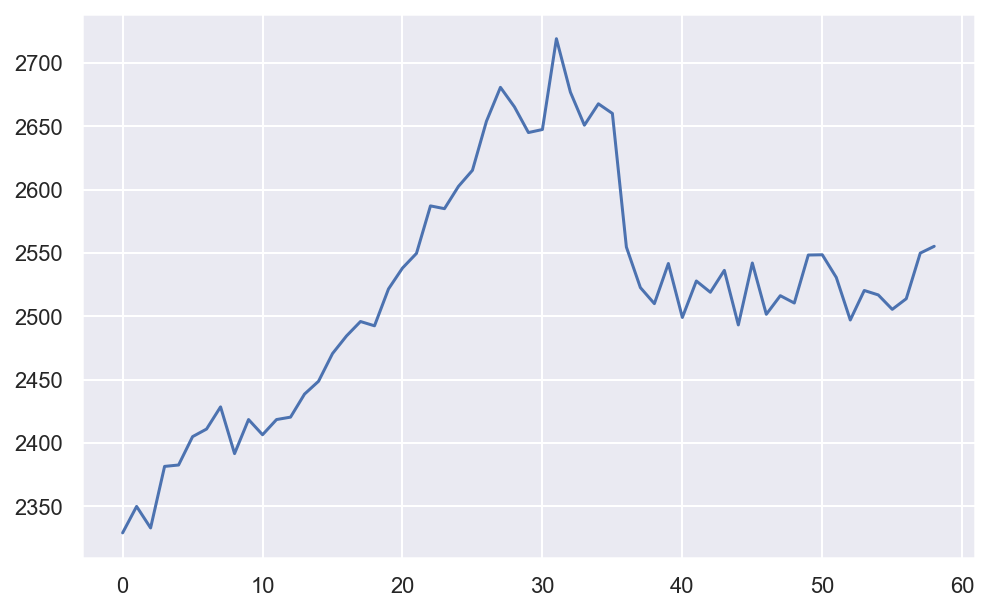

In [44]:
testing_series_11 = quarterly_dataset[quarterly_dataset["V1"] == "Q10"].squeeze().dropna().drop(index='V1')
testing_series_11.index = range(len(testing_series_11))
testing_series_11 = testing_series_11.astype(np.float64)
print(len(testing_series_11))
testing_series_11.plot()

### Ряд 12. Квартальный, размер = 63

63


<AxesSubplot:>

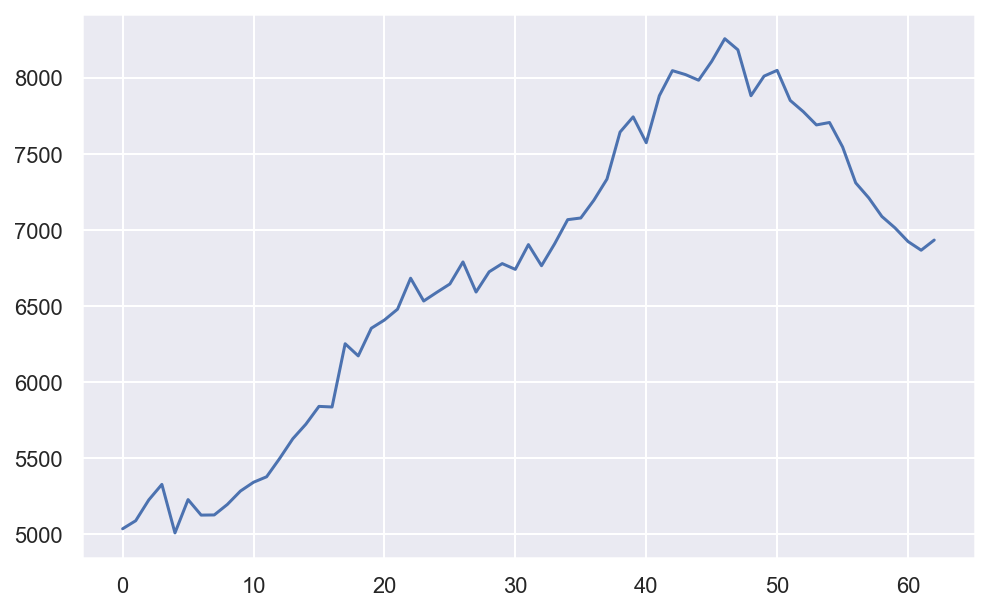

In [45]:
testing_series_12 = quarterly_dataset[quarterly_dataset["V1"] == "Q100"].squeeze().dropna().drop(index='V1')
testing_series_12.index = range(len(testing_series_12))
testing_series_12 = testing_series_12.astype(np.float64)
print(len(testing_series_12))
testing_series_12.plot()

### Ряд 13. Годовой, размер = 31

31


<AxesSubplot:>

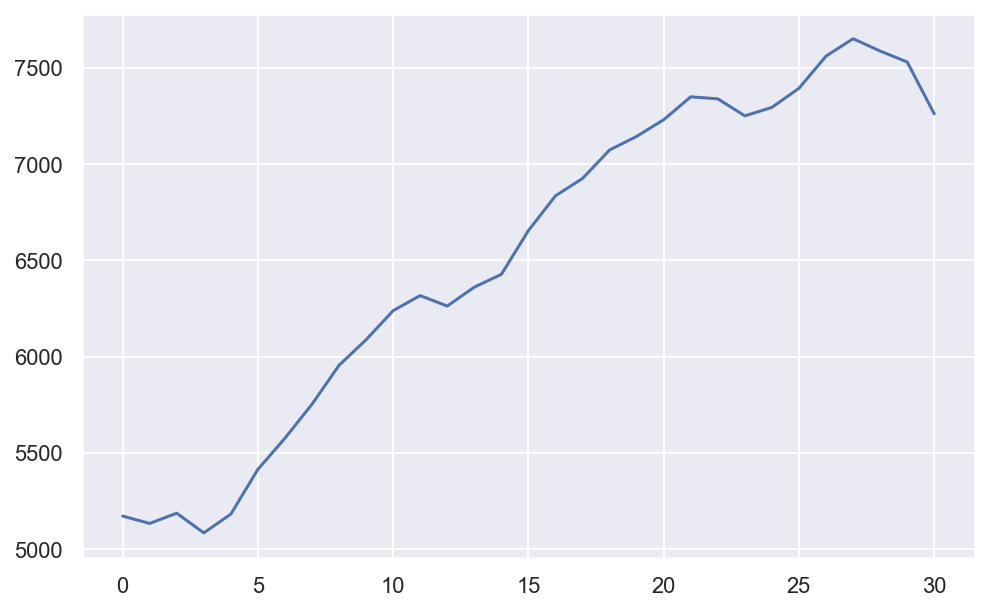

In [47]:
yearly_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Yearly-train.csv")
testing_series_13 = yearly_dataset[yearly_dataset["V1"] == "Y1"].squeeze().dropna().drop(index='V1')
testing_series_13.index = range(len(testing_series_13))
testing_series_13 = testing_series_13.astype(np.float64)
print(len(testing_series_13))
testing_series_13.plot()

### Ряд 14. Годовой, размер = 19

19


<AxesSubplot:>

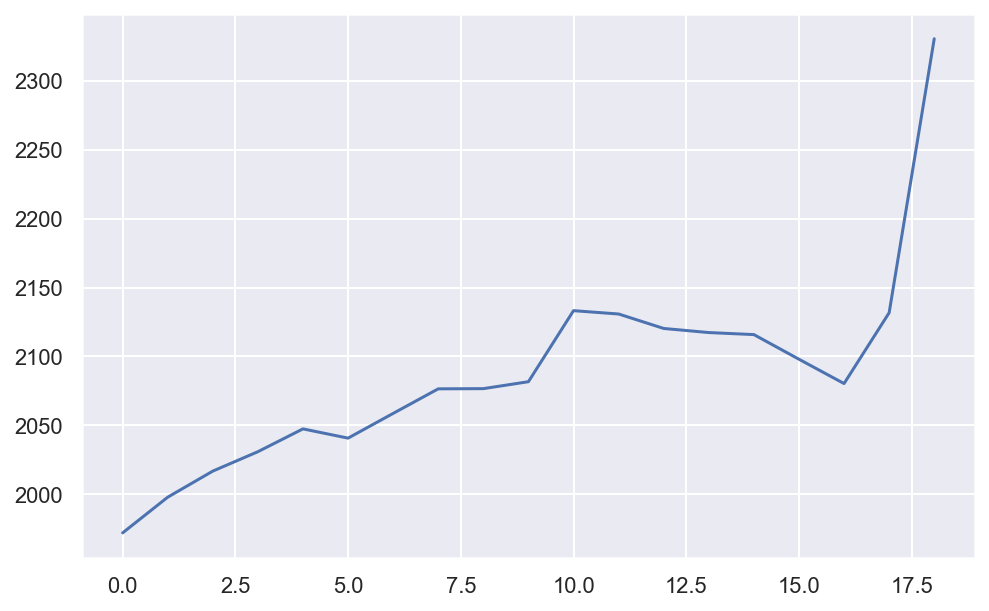

In [49]:
testing_series_14 = yearly_dataset[yearly_dataset["V1"] == "Y10"].squeeze().dropna().drop(index='V1')
testing_series_14.index = range(len(testing_series_14))
testing_series_14 = testing_series_14.astype(np.float64)
print(len(testing_series_14))
testing_series_14.plot()

### Ряд 15. Годовой, размер = 54

54


<AxesSubplot:>

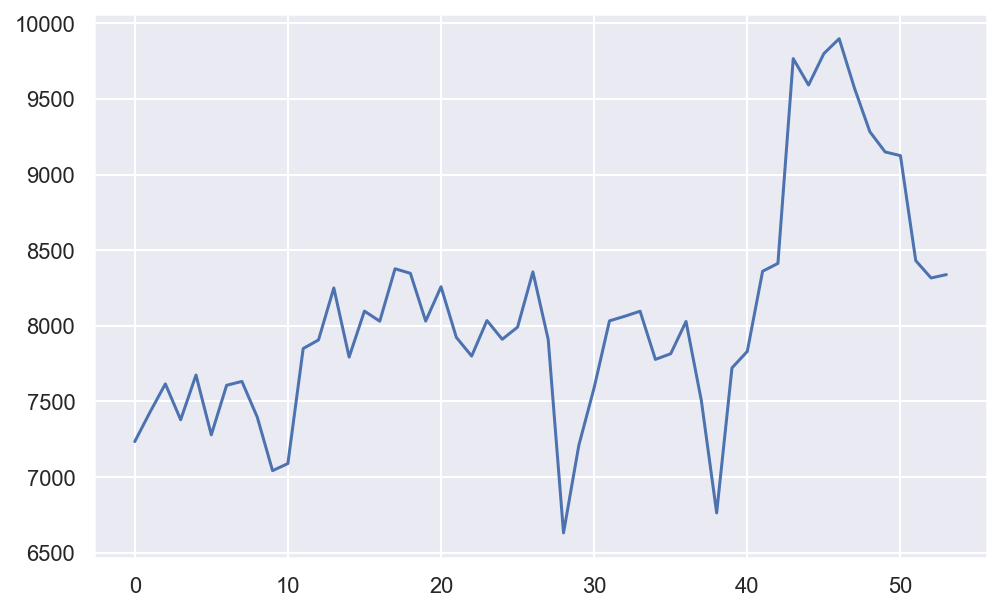

In [50]:
testing_series_15 = yearly_dataset[yearly_dataset["V1"] == "Y100"].squeeze().dropna().drop(index='V1')
testing_series_15.index = range(len(testing_series_15))
testing_series_15 = testing_series_15.astype(np.float64)
print(len(testing_series_15))
testing_series_15.plot()